# **Convolutional Neural Network Notebook**

## Objectives
Answer business requirement 2:
The client is interested to tell whether a given cell contains a malaria parasite or not.

## Inputs
inputs/leaves_dataset/cherry-leaves/processed_images/test
inputs/leaves_dataset/cherry-leaves/processed_images/train
inputs/leaves_dataset/cherry-leaves/processed_images/validation
image shape embeddings.

## Outputs
Image distribution plots for train, validation, and test sets.
Image augmentation.
Class indices to change prediction inference in labels.
Machine learning model creation and training.

---

Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

Set Working Directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves'

---

Setting Input Directories

In [4]:
my_data_dir = 'inputs/leaves_dataset/cherry-leaves/processed_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Setting Output Directory

In [5]:
import os
import shutil
import re

def get_version_folders(base_path):
    version_folders = []
    for folder in os.listdir(base_path):
        full_path = os.path.join(base_path, folder)
        if os.path.isdir(full_path) and re.match(r'^v\d+$', folder):
            version_folders.append((int(folder[1:]), folder))
    return sorted(version_folders)

def move_files_to_latest(base_path):
    version_folders = get_version_folders(base_path)
    if not version_folders:
        print("No version folders found.")
        return

    latest_version_num, latest_version = version_folders[-1]
    latest_path = os.path.join(base_path, latest_version)

    for version_num, version_name in version_folders[:-1]:
        version_path = os.path.join(base_path, version_name)
        for root, dirs, files in os.walk(version_path, topdown=False):
            for file in files:
                src_file = os.path.join(root, file)
                relative_path = os.path.relpath(src_file, version_path)
                dest_file = os.path.join(latest_path, relative_path)

                os.makedirs(os.path.dirname(dest_file), exist_ok=True)
                shutil.move(src_file, dest_file)

            for dir in dirs:
                dir_path = os.path.join(root, dir)
                if not os.listdir(dir_path):  # Remove empty subdirs
                    os.rmdir(dir_path)

        # After moving, remove version folder if empty
        if not os.listdir(version_path):
            os.rmdir(version_path)
            print(f"Removed empty folder: {version_name}")

    print(f"✅ All files moved to: {latest_version}")

if __name__ == "__main__":
    base_directory = '/workspaces/PP5-Cherry-Leaves/outputs'  # 🔧 Change this to your folder path
    move_files_to_latest(base_directory)

✅ All files moved to: v13


Setting Labels

In [6]:
labels = os.listdir(train_path)

print(
    f"Cherry Leaf Labels are: {labels}"
)

Cherry Leaf Labels are: ['powdery_mildew', 'healthy']


Setting Image Shape

In [12]:
import joblib
version = 'v6'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape_1.pkl")
image_shape

(100, 100, 3)

---

Number of images in Train, Test and Validation datasets

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 315 images
* validation - healthy: 315 images
* test - powdery_mildew: 317 images
* test - healthy: 317 images




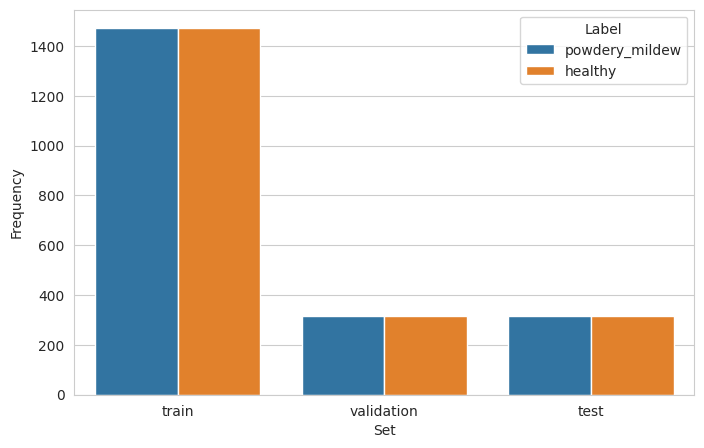

In [13]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-31 10:54:44.022309: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 10:54:44.052414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialise ImageDataGenerator for Image Augmentation

In [15]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Augmenting Training images dataset

In [16]:
batch_size = 10  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augmenting Validation images dataset

In [17]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 630 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augmenting Testing images dataset

In [18]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 634 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augmented training image

(10, 100, 100, 3)


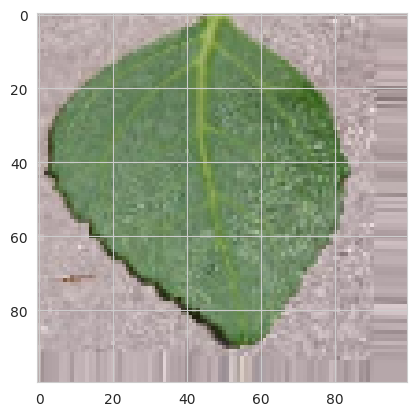

(10, 100, 100, 3)


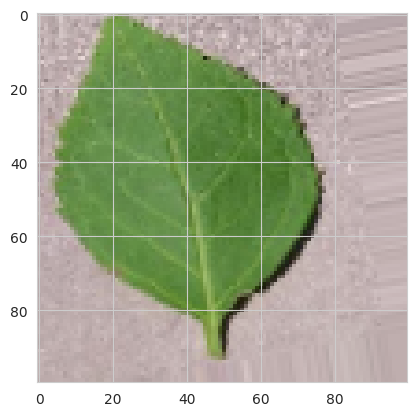

(10, 100, 100, 3)


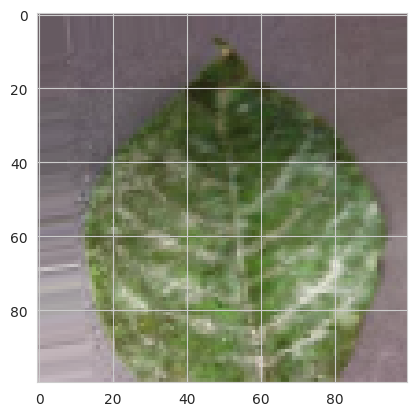

In [19]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,100,100,3)
    plt.imshow(img[0])
    plt.show()

Augmented Validation image

(10, 100, 100, 3)


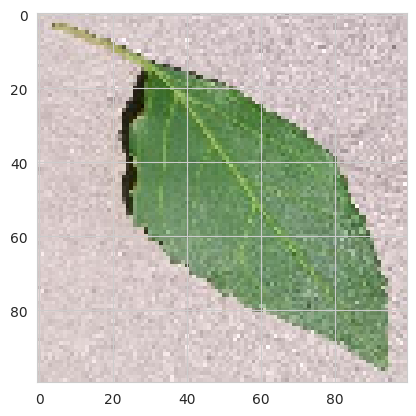

(10, 100, 100, 3)


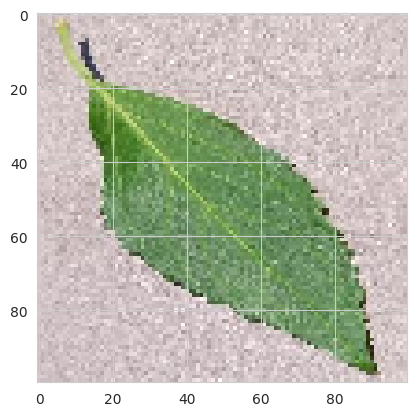

(10, 100, 100, 3)


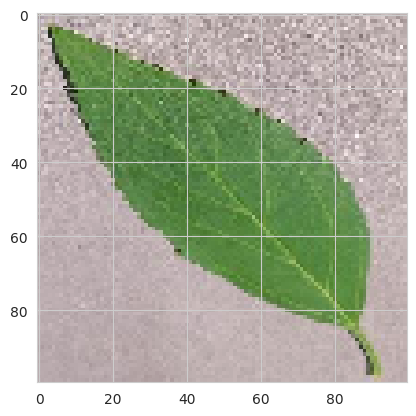

In [20]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,100,100,3)
    plt.imshow(img[0])
    plt.show()

Augmented testing image

(10, 100, 100, 3)


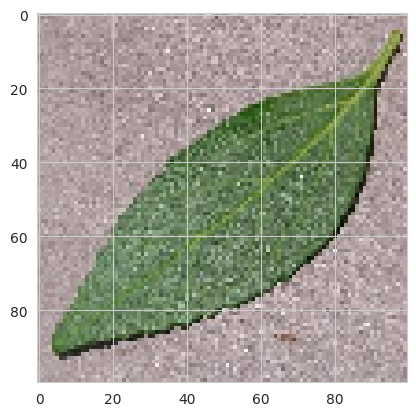

(10, 100, 100, 3)


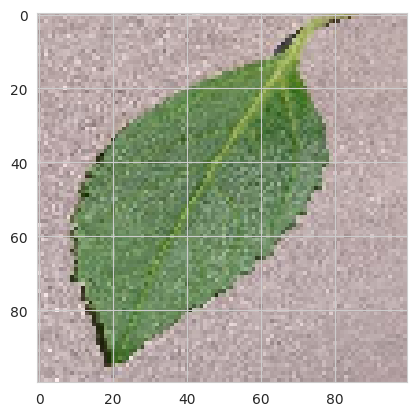

(10, 100, 100, 3)


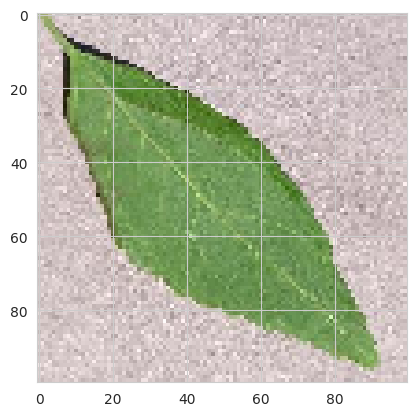

In [21]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,100,100,3)
    plt.imshow(img[0])
    plt.show()

Save Class Indices

In [22]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['/workspaces/PP5-Cherry-Leaves/outputs/v7/class_indices.pkl']